# Transfer Learning

Most of the time you won't want to train a whole convolutional network yourself. Modern ConvNets training on huge datasets like ImageNet take weeks on multiple GPUs. Instead, most people use a pretrained network either as a fixed feature extractor, or as an initial network to fine tune. In this notebook, you'll be using [VGGNet](https://arxiv.org/pdf/1409.1556.pdf) trained on the [ImageNet dataset](http://www.image-net.org/) as a feature extractor. Below is a diagram of the VGGNet architecture.

<img src="assets/cnnarchitecture.jpg" width=700px>

VGGNet is great because it's simple and has great performance, coming in second in the ImageNet competition. The idea here is that we keep all the convolutional layers, but replace the final fully connected layers with our own classifier. This way we can use VGGNet as a feature extractor for our images then easily train a simple classifier on top of that. What we'll do is take the first fully connected layer with 4096 units, including thresholding with ReLUs. We can use those values as a code for each image, then build a classifier on top of those codes.

You can read more about transfer learning from [the CS231n course notes](http://cs231n.github.io/transfer-learning/#tf).

## Pretrained VGGNet

We'll be using a pretrained network from https://github.com/machrisaa/tensorflow-vgg. 

This is a really nice implementation of VGGNet, quite easy to work with. The network has already been trained and the parameters are available from this link. 

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

vgg_dir = 'tensorflow_vgg/'
# Make sure vgg exists
if not isdir(vgg_dir):
    raise Exception("VGG directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(vgg_dir + "vgg16.npy"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='VGG16 Parameters') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/content.udacity-data.com/nd101/vgg16.npy',
            vgg_dir + 'vgg16.npy',
            pbar.hook)
else:
    print("Parameter file already exists!")

Parameter file already exists!


## ConvNet Codes

Below, we'll run through all the images in our dataset and get codes for each of them. That is, we'll run the images through the VGGNet convolutional layers and record the values of the first fully connected layer. We can then write these to a file for later when we build our own classifier.

Here we're using the `vgg16` module from `tensorflow_vgg`. The network takes images of size $244 \times 224 \times 3$ as input. Then it has 5 sets of convolutional layers. The network implemented here has this structure (copied from [the source code](https://github.com/machrisaa/tensorflow-vgg/blob/master/vgg16.py):

```
self.conv1_1 = self.conv_layer(bgr, "conv1_1")
self.conv1_2 = self.conv_layer(self.conv1_1, "conv1_2")
self.pool1 = self.max_pool(self.conv1_2, 'pool1')

self.conv2_1 = self.conv_layer(self.pool1, "conv2_1")
self.conv2_2 = self.conv_layer(self.conv2_1, "conv2_2")
self.pool2 = self.max_pool(self.conv2_2, 'pool2')

self.conv3_1 = self.conv_layer(self.pool2, "conv3_1")
self.conv3_2 = self.conv_layer(self.conv3_1, "conv3_2")
self.conv3_3 = self.conv_layer(self.conv3_2, "conv3_3")
self.pool3 = self.max_pool(self.conv3_3, 'pool3')

self.conv4_1 = self.conv_layer(self.pool3, "conv4_1")
self.conv4_2 = self.conv_layer(self.conv4_1, "conv4_2")
self.conv4_3 = self.conv_layer(self.conv4_2, "conv4_3")
self.pool4 = self.max_pool(self.conv4_3, 'pool4')

self.conv5_1 = self.conv_layer(self.pool4, "conv5_1")
self.conv5_2 = self.conv_layer(self.conv5_1, "conv5_2")
self.conv5_3 = self.conv_layer(self.conv5_2, "conv5_3")
self.pool5 = self.max_pool(self.conv5_3, 'pool5')

self.fc6 = self.fc_layer(self.pool5, "fc6")
self.relu6 = tf.nn.relu(self.fc6)
```

So what we want are the values of the first fully connected layer, after being ReLUd (`self.relu6`). To build the network, we use

```
with tf.Session() as sess:
    vgg = vgg16.Vgg16()
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
    with tf.name_scope("content_vgg"):
        vgg.build(input_)
```

This creates the `vgg` object, then builds the graph with `vgg.build(input_)`. Then to get the values from the layer,

```
feed_dict = {input_: images}
codes = sess.run(vgg.relu6, feed_dict=feed_dict)
```

In [3]:
import os

import numpy as np
import tensorflow as tf

from tensorflow_vgg import vgg16
from tensorflow_vgg import utils

In [4]:
data_dir = 'dataset/'
contents = os.listdir(data_dir)
classes = [each for each in contents if os.path.isdir(data_dir + each)]

In [5]:
print(classes)

['real', 'fake']


Below I'm running images through the VGG network in batches.

In [6]:
# Set the batch size higher if you can fit in in your GPU memory
batch_size = 10
codes_list = []
labels = []
batch = []

codes = None

with tf.Session() as sess:
    vgg = vgg16.Vgg16()
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
    with tf.name_scope("content_vgg"):
        vgg.build(input_)

    for each in classes:
        print("Starting {} images".format(each))
        class_path = data_dir + each
        files = os.listdir(class_path)
        for ii, file in enumerate(files, 1):
            # Add images to the current batch
            # utils.load_image crops the input images for us, from the center
            img = utils.load_image(os.path.join(class_path, file))
            batch.append(img.reshape((1, 224, 224, 3)))
            labels.append(each)
            
            # Running the batch through the network to get the codes
            if ii % batch_size == 0 or ii == len(files):
                images = np.concatenate(batch)

                feed_dict = {input_: images}
                codes_batch = sess.run(vgg.relu6, feed_dict=feed_dict)
                
                # Here I'm building an array of the codes
                if codes is None:
                    codes = codes_batch
                else:
                    codes = np.concatenate((codes, codes_batch))
                
                # Reset to start building the next batch
                batch = []
                print('{} images processed'.format(ii))

/Users/cathylin/Desktop/EECS 349/Final_Project/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 3s
Starting real images


/anaconda3/envs/dlnd/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10 images processed
20 images processed
30 images processed
40 images processed
50 images processed
60 images processed
70 images processed
80 images processed
90 images processed
100 images processed
110 images processed
120 images processed
130 images processed
140 images processed
150 images processed
160 images processed
170 images processed
180 images processed
190 images processed
200 images processed
210 images processed
220 images processed
230 images processed
240 images processed
250 images processed
260 images processed
270 images processed
280 images processed
290 images processed
300 images processed
310 images processed
320 images processed
330 images processed
340 images processed
350 images processed
360 images processed
370 images processed
380 images processed
390 images processed
400 images processed
410 images processed
420 images processed
430 images processed
440 images processed
450 images processed
460 images processed
470 images processed
480 images processed
4

In [7]:
# write codes to file
with open('nn_codes', 'w') as f:
    codes.tofile(f)
    
# write labels to file
import csv
with open('nn_labels', 'w') as f:
    writer = csv.writer(f, delimiter='\n')
    writer.writerow(labels)

## Building the Classifier

Now that we have codes for all the images, we can build a simple classifier on top of them. The codes behave just like normal input into a simple neural network. Below I'm going to have you do most of the work.

In [8]:
print(type(labels))

<class 'list'>


In [9]:
print(labels)

['real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real',

In [10]:
# read codes and labels from file
import csv

with open('nn_labels') as f:
    reader = csv.reader(f, delimiter='\n')
    labels = np.array([each for each in reader if len(each) > 0]).squeeze()
with open('nn_codes') as f:
    codes = np.fromfile(f, dtype=np.float32)
    codes = codes.reshape((len(labels), -1))

In [11]:
print(codes.shape)

(1526, 4096)


In [12]:
print(codes[0])

[0.        0.        1.5262582 ... 2.821091  0.        2.3106177]


In [13]:
print(codes[0].shape)

(4096,)


In [14]:
print(labels[0])

real


In [15]:
print(labels[239])

real


In [16]:
print(labels.shape)

(1526,)


### Data prep

As usual, now we need to one-hot encode our labels and create validation/test sets. First up, creating our labels!

> **Exercise:** From scikit-learn, use [LabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html) to create one-hot encoded vectors from the labels. 

In [17]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer() 
label = lb.fit_transform(['yes', 'no', 'no', 'yes']) 

label = np.hstack((label, 1 - label))

In [18]:
print(label)

[[1 0]
 [0 1]
 [0 1]
 [1 0]]


In [19]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
labels_vecs = lb.fit_transform(labels)
labels_vecs = np.hstack((labels_vecs, 1 - labels_vecs))

In [20]:
print(labels[0])

real


In [21]:
print(labels_vecs[0])

[1 0]


In [22]:
print(labels[239])

real


In [23]:
print(labels_vecs[239])

[1 0]


In [24]:
print(labels_vecs.shape)

(1526, 2)


Now you'll want to create your training, validation, and test sets. An important thing to note here is that our labels and data aren't randomized yet. We'll want to shuffle our data so the validation and test sets contain data from all classes. Otherwise, you could end up with testing sets that are all one class. Typically, you'll also want to make sure that each smaller set has the same the distribution of classes as it is for the whole data set. The easiest way to accomplish both these goals is to use [`StratifiedShuffleSplit`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) from scikit-learn.

You can create the splitter like so:
```
ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
```
Then split the data with 
```
splitter = ss.split(x, y)
```

`ss.split` returns a generator of indices. You can pass the indices into the arrays to get the split sets. The fact that it's a generator means you either need to iterate over it, or use `next(splitter)` to get the indices. Be sure to read the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) and the [user guide](http://scikit-learn.org/stable/modules/cross_validation.html#random-permutations-cross-validation-a-k-a-shuffle-split).

> **Exercise:** Use StratifiedShuffleSplit to split the codes and labels into training, validation, and test sets.

In [25]:
from sklearn.model_selection import StratifiedShuffleSplit

ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

train_idx, val_idx = next(ss.split(codes, labels_vecs))

half_val_len = int(len(val_idx)/2)
val_idx, test_idx = val_idx[:half_val_len], val_idx[half_val_len:]

train_x, train_y = codes[train_idx], labels_vecs[train_idx]
val_x, val_y = codes[val_idx], labels_vecs[val_idx]
test_x, test_y = codes[test_idx], labels_vecs[test_idx]

In [26]:
print("Train shapes (x, y):", train_x.shape, train_y.shape)
print("Validation shapes (x, y):", val_x.shape, val_y.shape)
print("Test shapes (x, y):", test_x.shape, test_y.shape)

Train shapes (x, y): (1220, 4096) (1220, 2)
Validation shapes (x, y): (153, 4096) (153, 2)
Test shapes (x, y): (153, 4096) (153, 2)


If you did it right, you should see these sizes for the training sets:

```
Train shapes (x, y): (2936, 4096) (2936, 5)
Validation shapes (x, y): (367, 4096) (367, 5)
Test shapes (x, y): (367, 4096) (367, 5)
```

### Classifier layers

Once you have the convolutional codes, you just need to build a classfier from some fully connected layers. You use the codes as the inputs and the image labels as targets. Otherwise the classifier is a typical neural network.

> **Exercise:** With the codes and labels loaded, build the classifier. Consider the codes as your inputs, each of them are 4096D vectors. You'll want to use a hidden layer and an output layer as your classifier. Remember that the output layer needs to have one unit for each class and a softmax activation function. Use the cross entropy to calculate the cost.

In [27]:
print(codes.shape[1])

4096


In [28]:
print(labels_vecs.shape[1])

2


In [29]:
inputs_ = tf.placeholder(tf.float32, shape=[None, codes.shape[1]])
labels_ = tf.placeholder(tf.int64, shape=[None, labels_vecs.shape[1]])

fc = tf.contrib.layers.fully_connected(inputs_, 256)
    
logits = tf.contrib.layers.fully_connected(fc, labels_vecs.shape[1], activation_fn=None)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=labels_, logits=logits)
cost = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer().minimize(cost)

predicted = tf.nn.softmax(logits)
print('predicted -> ',predicted)
correct_pred = tf.equal(tf.argmax(predicted, 1), tf.argmax(labels_, 1))
#correct_pred = tf.equal(predicted, labels_)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

predicted ->  Tensor("Softmax:0", shape=(?, 2), dtype=float32)


### Batches!

Here is just a simple way to do batches. I've written it so that it includes all the data. Sometimes you'll throw out some data at the end to make sure you have full batches. Here I just extend the last batch to include the remaining data.

In [30]:
def get_batches(x, y, n_batches=10):
    """ Return a generator that yields batches from arrays x and y. """
    batch_size = len(x)//n_batches
    
    for ii in range(0, n_batches*batch_size, batch_size):
        # If we're not on the last batch, grab data with size batch_size
        if ii != (n_batches-1)*batch_size:
            X, Y = x[ii: ii+batch_size], y[ii: ii+batch_size] 
        # On the last batch, grab the rest of the data
        else:
            X, Y = x[ii:], y[ii:]
        # I love generators
        yield X, Y

### Training

Here, we'll train the network.

> **Exercise:** So far we've been providing the training code for you. Here, I'm going to give you a bit more of a challenge and have you write the code to train the network. Of course, you'll be able to see my solution if you need help.

In [31]:
print(train_x.shape)

(1220, 4096)


In [32]:
print(train_y.shape)

(1220, 2)


In [33]:
for (x,y) in zip(train_x, train_y):
    print('x ', x, '-> y',y)

x  [0.         0.         0.91336906 ... 0.         0.         4.6509385 ] -> y [0 1]
x  [0.       0.       0.       ... 1.916561 0.       0.      ] -> y [1 0]
x  [0.        0.        0.        ... 1.1612098 0.        0.       ] -> y [1 0]
x  [0.        0.        0.        ... 2.1391444 0.        7.4755325] -> y [1 0]
x  [0.         0.         0.         ... 0.65849394 0.         5.8598886 ] -> y [0 1]
x  [0.        0.8295496 1.6438203 ... 1.9308976 0.        0.       ] -> y [1 0]
x  [0.         0.         0.41805518 ... 0.         0.         1.4790134 ] -> y [1 0]
x  [0.         0.         0.         ... 0.26411653 0.         3.881471  ] -> y [1 0]
x  [0.        0.        0.        ... 4.4760776 0.        4.5696087] -> y [1 0]
x  [0.         0.         0.69048214 ... 2.557351   0.         0.        ] -> y [0 1]
x  [0.        0.        0.        ... 4.0669756 0.        5.0137157] -> y [0 1]
x  [0.        0.        0.        ... 3.4311824 0.        0.6580312] -> y [1 0]
x  [0.        0.

x  [0.        0.        0.        ... 0.        0.        6.8508244] -> y [1 0]
x  [0.       0.       0.       ... 0.       0.       5.827658] -> y [1 0]
x  [0.        0.        1.9000088 ... 6.3716006 0.        0.       ] -> y [1 0]
x  [0.        0.        0.5858194 ... 3.357929  0.        7.198435 ] -> y [0 1]
x  [0.        0.        0.7612287 ... 4.3605933 0.        2.02906  ] -> y [1 0]
x  [0.        0.797489  1.5484797 ... 0.        0.        0.       ] -> y [0 1]
x  [0. 0. 0. ... 0. 0. 0.] -> y [0 1]
x  [0.        0.        0.        ... 0.9962869 0.        3.5892859] -> y [1 0]
x  [0.        0.        0.        ... 2.869959  0.        2.4762628] -> y [1 0]
x  [0.        0.        0.        ... 0.        0.        3.0357418] -> y [1 0]
x  [0.         0.         0.09697399 ... 3.0758493  0.         4.837883  ] -> y [0 1]
x  [0.       0.       1.424573 ... 0.       0.       6.045735] -> y [0 1]
x  [0.        0.        0.        ... 0.4781435 0.        8.806314 ] -> y [1 0]
x  [0. 0

x  [0.         0.         0.         ... 0.26109123 0.         2.502366  ] -> y [1 0]
x  [0.        0.        0.        ... 2.1363177 0.        4.541899 ] -> y [0 1]
x  [0.         0.         0.08881882 ... 2.0945425  0.         4.7142515 ] -> y [1 0]
x  [0.        0.        0.        ... 0.        0.        6.3892174] -> y [0 1]
x  [0.        0.        0.        ... 3.4074442 0.        6.1611924] -> y [0 1]
x  [0.         0.         3.8150015  ... 0.08099602 0.         5.019921  ] -> y [1 0]
x  [0.        0.        0.        ... 3.7067535 0.        4.82563  ] -> y [0 1]
x  [0.        0.        0.        ... 2.1447806 0.        4.2810993] -> y [0 1]
x  [0.        0.        0.7358885 ... 5.7278466 0.        1.3782247] -> y [1 0]
x  [0.        0.        0.        ... 0.        0.        3.9680197] -> y [1 0]
x  [0.        0.        8.02652   ... 1.2271817 0.        4.588537 ] -> y [1 0]
x  [0.        0.        2.1854014 ... 3.6279933 0.        4.177979 ] -> y [0 1]
x  [0.        0.      

x  [0.        0.        0.        ... 0.7216132 0.        0.       ] -> y [1 0]
x  [0.        0.        5.490759  ... 0.        0.        4.7755303] -> y [0 1]
x  [0.        0.        0.        ... 0.8389885 0.        4.5132113] -> y [0 1]
x  [0.        0.        1.3822166 ... 1.8743235 0.        9.683198 ] -> y [0 1]
x  [0.       0.       0.       ... 6.481763 0.       0.      ] -> y [1 0]
x  [0.        0.        0.        ... 0.        0.        4.3304915] -> y [1 0]
x  [0.        1.6639017 8.876441  ... 0.        0.        0.       ] -> y [1 0]
x  [0.         0.         3.3233228  ... 0.31691748 0.         1.1759449 ] -> y [0 1]
x  [0.        0.        0.        ... 1.4979455 0.        4.999095 ] -> y [1 0]
x  [0.        0.        0.        ... 2.1875577 0.        4.060024 ] -> y [0 1]
x  [0.        0.        5.171084  ... 2.1547446 0.        0.       ] -> y [0 1]
x  [0.        0.        0.        ... 3.5464785 0.        2.831648 ] -> y [0 1]
x  [0.       0.       0.       ... 4.926

In [34]:
epochs = 100
iteration = 0
saver = tf.train.Saver()
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for x, y in get_batches(train_x, train_y):
            #print('---------->')
            #print('x',x)
            #print('y',y)
            feed = {inputs_: x,
                    labels_: y}
            loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            print("Epoch: {}/{}".format(e+1, epochs),
                  "Iteration: {}".format(iteration),
                  "Training loss: {:.5f}".format(loss))
            iteration += 1
            
            if iteration % 5 == 0:
                feed = {inputs_: val_x,
                        labels_: val_y}
                val_acc = sess.run(accuracy, feed_dict=feed)
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Validation Acc: {:.4f}".format(val_acc))
    saver.save(sess, "checkpoints/hand.ckpt")

Epoch: 1/100 Iteration: 0 Training loss: 1.68111
Epoch: 1/100 Iteration: 1 Training loss: 38.72105
Epoch: 1/100 Iteration: 2 Training loss: 19.91630
Epoch: 1/100 Iteration: 3 Training loss: 5.17299
Epoch: 1/100 Iteration: 4 Training loss: 2.22227
Epoch: 0/100 Iteration: 5 Validation Acc: 0.5229
Epoch: 1/100 Iteration: 5 Training loss: 3.92104
Epoch: 1/100 Iteration: 6 Training loss: 3.31787
Epoch: 1/100 Iteration: 7 Training loss: 2.43476
Epoch: 1/100 Iteration: 8 Training loss: 1.96210
Epoch: 1/100 Iteration: 9 Training loss: 1.11088
Epoch: 0/100 Iteration: 10 Validation Acc: 0.6863
Epoch: 2/100 Iteration: 10 Training loss: 0.58743
Epoch: 2/100 Iteration: 11 Training loss: 0.60390
Epoch: 2/100 Iteration: 12 Training loss: 0.73749
Epoch: 2/100 Iteration: 13 Training loss: 0.88737
Epoch: 2/100 Iteration: 14 Training loss: 1.02996
Epoch: 1/100 Iteration: 15 Validation Acc: 0.4837
Epoch: 2/100 Iteration: 15 Training loss: 0.86327
Epoch: 2/100 Iteration: 16 Training loss: 0.83321
Epoch: 2/

Epoch: 15/100 Iteration: 142 Training loss: 0.14673
Epoch: 15/100 Iteration: 143 Training loss: 0.15259
Epoch: 15/100 Iteration: 144 Training loss: 0.12973
Epoch: 14/100 Iteration: 145 Validation Acc: 0.8954
Epoch: 15/100 Iteration: 145 Training loss: 0.08494
Epoch: 15/100 Iteration: 146 Training loss: 0.08319
Epoch: 15/100 Iteration: 147 Training loss: 0.11032
Epoch: 15/100 Iteration: 148 Training loss: 0.11883
Epoch: 15/100 Iteration: 149 Training loss: 0.12727
Epoch: 14/100 Iteration: 150 Validation Acc: 0.8954
Epoch: 16/100 Iteration: 150 Training loss: 0.10623
Epoch: 16/100 Iteration: 151 Training loss: 0.09279
Epoch: 16/100 Iteration: 152 Training loss: 0.12145
Epoch: 16/100 Iteration: 153 Training loss: 0.12326
Epoch: 16/100 Iteration: 154 Training loss: 0.10574
Epoch: 15/100 Iteration: 155 Validation Acc: 0.9020
Epoch: 16/100 Iteration: 155 Training loss: 0.07115
Epoch: 16/100 Iteration: 156 Training loss: 0.06300
Epoch: 16/100 Iteration: 157 Training loss: 0.09410
Epoch: 16/10

Epoch: 29/100 Iteration: 286 Training loss: 0.02551
Epoch: 29/100 Iteration: 287 Training loss: 0.03098
Epoch: 29/100 Iteration: 288 Training loss: 0.03741
Epoch: 29/100 Iteration: 289 Training loss: 0.04175
Epoch: 28/100 Iteration: 290 Validation Acc: 0.9085
Epoch: 30/100 Iteration: 290 Training loss: 0.04251
Epoch: 30/100 Iteration: 291 Training loss: 0.02296
Epoch: 30/100 Iteration: 292 Training loss: 0.03829
Epoch: 30/100 Iteration: 293 Training loss: 0.04639
Epoch: 30/100 Iteration: 294 Training loss: 0.03144
Epoch: 29/100 Iteration: 295 Validation Acc: 0.8824
Epoch: 30/100 Iteration: 295 Training loss: 0.01994
Epoch: 30/100 Iteration: 296 Training loss: 0.02235
Epoch: 30/100 Iteration: 297 Training loss: 0.03443
Epoch: 30/100 Iteration: 298 Training loss: 0.02731
Epoch: 30/100 Iteration: 299 Training loss: 0.03840
Epoch: 29/100 Iteration: 300 Validation Acc: 0.8824
Epoch: 31/100 Iteration: 300 Training loss: 0.03310
Epoch: 31/100 Iteration: 301 Training loss: 0.02089
Epoch: 31/10

Epoch: 43/100 Iteration: 429 Training loss: 0.01617
Epoch: 42/100 Iteration: 430 Validation Acc: 0.8758
Epoch: 44/100 Iteration: 430 Training loss: 0.01540
Epoch: 44/100 Iteration: 431 Training loss: 0.00908
Epoch: 44/100 Iteration: 432 Training loss: 0.01385
Epoch: 44/100 Iteration: 433 Training loss: 0.01845
Epoch: 44/100 Iteration: 434 Training loss: 0.01290
Epoch: 43/100 Iteration: 435 Validation Acc: 0.8758
Epoch: 44/100 Iteration: 435 Training loss: 0.01002
Epoch: 44/100 Iteration: 436 Training loss: 0.00791
Epoch: 44/100 Iteration: 437 Training loss: 0.01172
Epoch: 44/100 Iteration: 438 Training loss: 0.01079
Epoch: 44/100 Iteration: 439 Training loss: 0.01516
Epoch: 43/100 Iteration: 440 Validation Acc: 0.8758
Epoch: 45/100 Iteration: 440 Training loss: 0.01455
Epoch: 45/100 Iteration: 441 Training loss: 0.00861
Epoch: 45/100 Iteration: 442 Training loss: 0.01298
Epoch: 45/100 Iteration: 443 Training loss: 0.01748
Epoch: 45/100 Iteration: 444 Training loss: 0.01238
Epoch: 44/10

Epoch: 57/100 Iteration: 568 Training loss: 0.00550
Epoch: 57/100 Iteration: 569 Training loss: 0.00777
Epoch: 56/100 Iteration: 570 Validation Acc: 0.8758
Epoch: 58/100 Iteration: 570 Training loss: 0.00709
Epoch: 58/100 Iteration: 571 Training loss: 0.00470
Epoch: 58/100 Iteration: 572 Training loss: 0.00656
Epoch: 58/100 Iteration: 573 Training loss: 0.00892
Epoch: 58/100 Iteration: 574 Training loss: 0.00660
Epoch: 57/100 Iteration: 575 Validation Acc: 0.8758
Epoch: 58/100 Iteration: 575 Training loss: 0.00516
Epoch: 58/100 Iteration: 576 Training loss: 0.00397
Epoch: 58/100 Iteration: 577 Training loss: 0.00555
Epoch: 58/100 Iteration: 578 Training loss: 0.00528
Epoch: 58/100 Iteration: 579 Training loss: 0.00744
Epoch: 57/100 Iteration: 580 Validation Acc: 0.8758
Epoch: 59/100 Iteration: 580 Training loss: 0.00679
Epoch: 59/100 Iteration: 581 Training loss: 0.00451
Epoch: 59/100 Iteration: 582 Training loss: 0.00631
Epoch: 59/100 Iteration: 583 Training loss: 0.00854
Epoch: 59/10

Epoch: 71/100 Iteration: 705 Training loss: 0.00325
Epoch: 71/100 Iteration: 706 Training loss: 0.00232
Epoch: 71/100 Iteration: 707 Training loss: 0.00334
Epoch: 71/100 Iteration: 708 Training loss: 0.00328
Epoch: 71/100 Iteration: 709 Training loss: 0.00419
Epoch: 70/100 Iteration: 710 Validation Acc: 0.8824
Epoch: 72/100 Iteration: 710 Training loss: 0.00407
Epoch: 72/100 Iteration: 711 Training loss: 0.00276
Epoch: 72/100 Iteration: 712 Training loss: 0.00392
Epoch: 72/100 Iteration: 713 Training loss: 0.00522
Epoch: 72/100 Iteration: 714 Training loss: 0.00399
Epoch: 71/100 Iteration: 715 Validation Acc: 0.8824
Epoch: 72/100 Iteration: 715 Training loss: 0.00313
Epoch: 72/100 Iteration: 716 Training loss: 0.00226
Epoch: 72/100 Iteration: 717 Training loss: 0.00326
Epoch: 72/100 Iteration: 718 Training loss: 0.00316
Epoch: 72/100 Iteration: 719 Training loss: 0.00406
Epoch: 71/100 Iteration: 720 Validation Acc: 0.8824
Epoch: 73/100 Iteration: 720 Training loss: 0.00392
Epoch: 73/10

Epoch: 84/100 Iteration: 845 Validation Acc: 0.8824
Epoch: 85/100 Iteration: 845 Training loss: 0.00219
Epoch: 85/100 Iteration: 846 Training loss: 0.00154
Epoch: 85/100 Iteration: 847 Training loss: 0.00216
Epoch: 85/100 Iteration: 848 Training loss: 0.00218
Epoch: 85/100 Iteration: 849 Training loss: 0.00267
Epoch: 84/100 Iteration: 850 Validation Acc: 0.8824
Epoch: 86/100 Iteration: 850 Training loss: 0.00267
Epoch: 86/100 Iteration: 851 Training loss: 0.00181
Epoch: 86/100 Iteration: 852 Training loss: 0.00266
Epoch: 86/100 Iteration: 853 Training loss: 0.00342
Epoch: 86/100 Iteration: 854 Training loss: 0.00269
Epoch: 85/100 Iteration: 855 Validation Acc: 0.8824
Epoch: 86/100 Iteration: 855 Training loss: 0.00212
Epoch: 86/100 Iteration: 856 Training loss: 0.00151
Epoch: 86/100 Iteration: 857 Training loss: 0.00212
Epoch: 86/100 Iteration: 858 Training loss: 0.00212
Epoch: 86/100 Iteration: 859 Training loss: 0.00261
Epoch: 85/100 Iteration: 860 Validation Acc: 0.8824
Epoch: 87/10

Epoch: 99/100 Iteration: 982 Training loss: 0.00196
Epoch: 99/100 Iteration: 983 Training loss: 0.00248
Epoch: 99/100 Iteration: 984 Training loss: 0.00198
Epoch: 98/100 Iteration: 985 Validation Acc: 0.8824
Epoch: 99/100 Iteration: 985 Training loss: 0.00154
Epoch: 99/100 Iteration: 986 Training loss: 0.00110
Epoch: 99/100 Iteration: 987 Training loss: 0.00147
Epoch: 99/100 Iteration: 988 Training loss: 0.00156
Epoch: 99/100 Iteration: 989 Training loss: 0.00187
Epoch: 98/100 Iteration: 990 Validation Acc: 0.8824
Epoch: 100/100 Iteration: 990 Training loss: 0.00188
Epoch: 100/100 Iteration: 991 Training loss: 0.00124
Epoch: 100/100 Iteration: 992 Training loss: 0.00191
Epoch: 100/100 Iteration: 993 Training loss: 0.00243
Epoch: 100/100 Iteration: 994 Training loss: 0.00194
Epoch: 99/100 Iteration: 995 Validation Acc: 0.8824
Epoch: 100/100 Iteration: 995 Training loss: 0.00151
Epoch: 100/100 Iteration: 996 Training loss: 0.00108
Epoch: 100/100 Iteration: 997 Training loss: 0.00142
Epoc

### Testing

Below you see the test accuracy. You can also see the predictions returned for images.

In [35]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: test_x,
            labels_: test_y}
    test_acc = sess.run(accuracy, feed_dict=feed)
    print("Test accuracy: {:.4f}".format(test_acc))

INFO:tensorflow:Restoring parameters from checkpoints/hand.ckpt
Test accuracy: 0.9346


In [36]:
%matplotlib inline

import matplotlib.pyplot as plt
from scipy.ndimage import imread

Below, feel free to choose images and see how the trained classifier predicts the flowers in them.

/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  


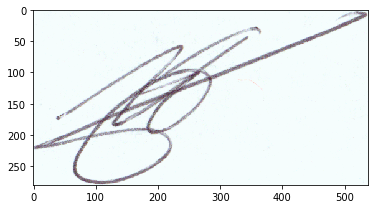

In [37]:
test_img_path = 'dataset/real/13_013.PNG'
test_img = imread(test_img_path)
plt.imshow(test_img)

In [38]:
# Run this cell if you don't have a vgg graph built
with tf.Session() as sess:
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
    vgg = vgg16.Vgg16()
    vgg.build(input_)

/Users/cathylin/Desktop/EECS 349/Final_Project/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 4s


In [39]:
with tf.Session() as sess:
    img = utils.load_image(test_img_path)
    img = img.reshape((1, 224, 224, 3))

    feed_dict = {input_: img}
    code = sess.run(vgg.relu6, feed_dict=feed_dict)
        
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: code}
    prediction = sess.run(predicted, feed_dict=feed).squeeze()

/anaconda3/envs/dlnd/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


INFO:tensorflow:Restoring parameters from checkpoints/hand.ckpt


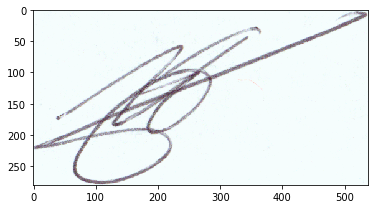

In [41]:
plt.imshow(test_img)

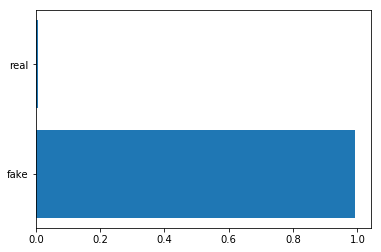

In [42]:
plt.barh(np.arange(2), prediction)
_ = plt.yticks(np.arange(2), lb.classes_)